# Convolutional Neural Networks

#### Giovanni Garifo - January 6, 2019

The CIFAR100 dataset is composed of 100 classes containing 600 images each, the images have a resolution of 32x32 pixels in RGB format.  Of the 600 images for a given class, 500 are used as training set, and 100 as test set.

We want to use different kinds of neural networks to classify the images in the test set.

In [11]:
!pip3 install -q http://download.pytorch.org/whl/cu90/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

In [0]:
###########################################
# SELECT THE MODEL THAT YOU WANT TO TRAIN #
###########################################

'''
NN: simple fully connected Neural Network
CNN_1: first  CNN, with number of filters for each convolutional layer: 32/32/32/34
CNN_2: second CNN, with number of filters for each convolutional layer: 128/128/128/256
CNN_3: second CNN, with number of filters for each convolutional layer: 256/256/256/512
CNN_4: second CNN, with number of filters for each convolutional layer: 512/512/512/1024
CNN_5: it's CNN_2 with batch normalization after each convolution layer
CNN_6: it's CNN_2 with batch normalization after each convolution layer, and FC1 wider (8192)
CNN_7: it's CNN_2 with batch normalization after each convolution layer, and dropout 0.5 on FC1
CNN_8: it's CNN_2 with data augmentation: random horizontal flip and random crop
CNN_9: ResNet18 pre-trained over ImageNet, with only changes to the FC layer, training set with data augmentation
'''
MODEL = "NN"


In [0]:
%matplotlib inline
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import numpy as np

In [0]:
####################
# Define constants #
####################

NUM_CLASSES = 100
NUM_EPOCHS = 20

In [0]:
#####################
# Utility functions #
#####################

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def plot_kernel(model):
    model_weights = model.state_dict()
    fig = plt.figure()
    plt.figure(figsize=(10,10))
    for idx, filt  in enumerate(model_weights['conv1.weight']):
    #print(filt[0, :, :])
        if idx >= 32: continue
        plt.subplot(4,8, idx + 1)
        plt.imshow(filt[0, :, :], cmap="gray")
        plt.axis('off')
    
    plt.show()

def plot_kernel_output(model,images):
    fig1 = plt.figure()
    plt.figure(figsize=(1,1))
    
    img_normalized = (images[0] - images[0].min()) / (images[0].max() - images[0].min())
    plt.imshow(img_normalized.numpy().transpose(1,2,0))
    plt.show()
    output = model.conv1(images)
    layer_1 = output[0, :, :, :]
    layer_1 = layer_1.data

    fig = plt.figure()
    plt.figure(figsize=(10,10))
    for idx, filt  in enumerate(layer_1):
        if idx >= 32: continue
        plt.subplot(4,8, idx + 1)
        plt.imshow(filt, cmap="gray")
        plt.axis('off')
    plt.show()
    
    
def plot_loss_accuracy_statistics(statistics):
  
  # plot loss
  loss_values = np.array(statistics[:,0]).T 
  accuracy_values = np.array(statistics[:,1]).T
  epochs_values = np.arange(NUM_EPOCHS)
  
  plt.figure(figsize=(12,4))
  
  plt.subplot(1, 2, 1)
 
 # plt.figure(1)
  plt.plot(epochs_values, loss_values, label="Loss")
  plt.xticks(epochs_values)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Loss behaviour")
  
  plt.subplot(1, 2, 2)
  #plt.figure(2)
  plt.plot(epochs_values, accuracy_values, label="Accuracy")
  plt.xticks(epochs_values)
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Accuracy behaviour")

  
  plt.show()
  

In [16]:
######################
# Dataset definition #
######################

#transform are heavily used to do simple and complex transformation and data augmentation

if MODEL == "CNN_8":
  transform_train = transforms.Compose(
    [
     transforms.RandomHorizontalFlip(),
     transforms.Resize((40,40)),
     transforms.RandomCrop((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
  transform_test = transforms.Compose(
    [
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])
elif MODEL == "CNN_9":
  transform_train = transforms.Compose(
    [
     transforms.RandomHorizontalFlip(),
     transforms.Resize((248,248)),
     transforms.RandomCrop((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
  transform_test = transforms.Compose(
    [
     transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])
else:
  transform_train = transforms.Compose(
    [
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
  transform_test = transforms.Compose(
    [
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])
  
print("Tranformations used for training set: \n")
print(transform_train)  

print("Tranformations used for test set: \n")
print(transform_test)
  
trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform_train)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=4,drop_last=True)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=4,drop_last=True)

dataiter = iter(trainloader)

Tranformations used for training set: 

Compose(
    Resize(size=(32, 32), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Tranformations used for test set: 

Compose(
    Resize(size=(32, 32), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Files already downloaded and verified


In [0]:
#################################
# Define Neural Network classes #
#################################

class old_nn(nn.Module):
    '''
    Class that defines an old style fully connected network (multilayer perceptrons)    
    '''
    
    # instantiate the neural network
    def __init__(self):
        super(old_nn, self).__init__()
        
        # First fully connected layer, perform a linear (z=w*x+b) transormation
        self.fc1 = nn.Linear(32*32*3, # number of input features
                             4096) # number of output features = number of neurons in first hidden layer
        
        # from first hidden layer to second hidden layer
        self.fc2 = nn.Linear(4096, 4096) 
        
        # from second hidden layer to output layer
        self.fc3 = nn.Linear(4096, NUM_CLASSES)

        
    # Perform forward pass
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x
      
      

class CNN_1234(nn.Module):
    '''
    Class that defines a Convolutional Neural Network
    '''

    def __init__(self):
        super(CNN_1234, self).__init__()
        #conv2d first parameter is the number of kernels at input (you get it from the output value of the previous layer)
        #conv2d second parameter is the number of kernels you wanna have in your convolution, so it will be the n. of kernels at output.
        #conv2d third, fourth and fifth parameters are, as you can read, kernel_size, stride and zero padding :)
        
        # OutputVolume formula: (inputWidth + 2*padding - kernelSize)/stride + 1
        
        # Input sample has size 32x32x3, first conv outputs 32 feature maps.
        # output volume size: (32+2*0-5)/2+1 = 30 => 14*14*32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=0)
        
        # output volume size of conv2: (14-3)+1 = 12 => 12*12*32
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0)
        
        # output volume size of conv3: (12-3)+1 = 10 => 10*10*32
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0)
        
        # output volume size of conv_final: (10-3)+1 = 8 => 8*8*64
        self.conv_final = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        
        # output volume size of pooling: (8-2)/2+1 = 4 => 4*4*64
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Linear(4*4*64, 4096)
        
        self.fc2 = nn.Linear(4096, NUM_CLASSES) #last FC for classification 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.pool(self.conv_final(x)))
        x = x.view(x.shape[0], -1) # needs reshape because fully connected layer take as input a row of values, not a volume!
        x = F.relu(self.fc1(x))
        #hint: dropout goes here!
        x = self.fc2(x)
        return x

      
class CNN_567(nn.Module):
    '''
    Class that defines a Convolutional Neural Network
    '''

    def __init__(self, dropout_probability):
        super(CNN_567, self).__init__()
                     
        self.conv1 = nn.Conv2d(3, 128, kernel_size=5, stride=2, padding=0)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
        self.conv_final = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0)
        
        # here's why i've set second parameter to false: https://discuss.pytorch.org/t/performance-highly-degraded-when-eval-is-activated-in-the-test-phase/3323/15#post_16
        self.bn = nn.BatchNorm2d(128, track_running_stats=False)     
        self.bn_final = nn.BatchNorm2d(256, track_running_stats=False)
    
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Linear(4*4*256, 4096)
        
        self.dropout = nn.Dropout2d(dropout_probability) # if it's zero, no dropout happens
        
        self.fc2 = nn.Linear(4096, NUM_CLASSES) #last FC for classification 
        
    def forward(self, x):
        x = F.relu(self.bn(self.conv1(x)))
        x = F.relu(self.bn(self.conv2(x)))
        x = F.relu(self.bn(self.conv3(x)))
        x = F.relu(self.pool(self.bn_final(self.conv_final(x))))
        x = x.view(x.shape[0], -1) # needs reshape because fully connected layer take as input a row of values, not a volume!
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [0]:
#########################################
# Define training and testing functions #
#########################################

def test_accuracy(net, dataloader):
    '''
    Testing phase, check accuracy over whole test test
    '''
    correct = 0
    total = 0
    net.eval() #important for deactivating dropout and correctly use batchnorm accumulated statistics
    
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
    
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print('Accuracy of the network on the test set: %d %%' % (accuracy))
    return accuracy
  


 - Starting Training of the model NN - 

[1,   390] loss: 4.121
Accuracy of the network on the test set: 11 %
Statistics saved for epoch=0: (loss=4.121, accuracy=11) 

[2,   390] loss: 3.698
Accuracy of the network on the test set: 15 %
Statistics saved for epoch=1: (loss=3.698, accuracy=15) 

[3,   390] loss: 3.534
Accuracy of the network on the test set: 17 %
Statistics saved for epoch=2: (loss=3.534, accuracy=17) 

[4,   390] loss: 3.412
Accuracy of the network on the test set: 19 %
Statistics saved for epoch=3: (loss=3.412, accuracy=19) 

[5,   390] loss: 3.309
Accuracy of the network on the test set: 20 %
Statistics saved for epoch=4: (loss=3.309, accuracy=20) 

[6,   390] loss: 3.216
Accuracy of the network on the test set: 21 %
Statistics saved for epoch=5: (loss=3.216, accuracy=21) 

[7,   390] loss: 3.135
Accuracy of the network on the test set: 22 %
Statistics saved for epoch=6: (loss=3.135, accuracy=22) 

[8,   390] loss: 3.063
Accuracy of the network on the test set: 23 %
S

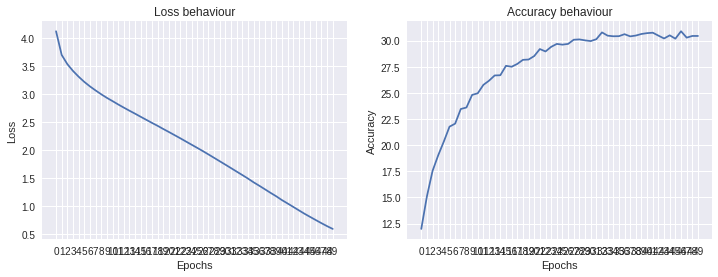

In [19]:
##############################
# Train the selected network #
##############################

if MODEL == "NN":
  net = old_nn()

elif MODEL == "CNN_1":
  net = CNN_1234()
  
elif MODEL == "CNN_2":
  net = CNN_1234()
  net.conv1 = nn.Conv2d(3, 128, kernel_size=5, stride=2, padding=0)
  net.conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
  net.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
  net.conv_final = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0)
  net.fc1 = nn.Linear(4*4*256, 4096)

elif MODEL == "CNN_3":
  net = CNN_1234()
  net.conv1 = nn.Conv2d(3, 256, kernel_size=5, stride=2, padding=0)
  net.conv2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0)
  net.conv3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0)
  net.conv_final = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=0)
  net.fc1 = nn.Linear(4*4*512, 4096)

elif MODEL == "CNN_4":
  net = CNN_1234()
  net.conv1 = nn.Conv2d(3, 512, kernel_size=5, stride=2, padding=0)
  net.conv2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=0)
  net.conv3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=0)
  net.conv_final = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=0)
  net.fc1 = nn.Linear(4*4*1024, 4096)

elif MODEL == "CNN_5":
  net = CNN_567(0) #no dropout

elif MODEL == "CNN_6":
  net = CNN_567(0) #no dropout
  net.fc1 = nn.Linear(4*4*256, 8192)        
  net.fc2 = nn.Linear(8192, NUM_CLASSES)
  
elif MODEL == "CNN_7":
  net = CNN_567(0.5) #dropout
  
elif MODEL == "CNN_8":
  net = CNN_1234()
  net.conv1 = nn.Conv2d(3, 128, kernel_size=5, stride=2, padding=0)
  net.conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
  net.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
  net.conv_final = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0)
  net.fc1 = nn.Linear(4*4*256, 4096)

elif MODEL == "CNN_9":
  net = models.resnet18(pretrained=True)
  net.fc = nn.Linear(512, NUM_CLASSES) #changing the fully connected layer of the already allocated network
  
  
net = net.cuda() # use GPU

# loss and accuracy statistics for each epoch
epoch_loss_accuracy = np.zeros(shape=(NUM_EPOCHS,2)) 

# use negative log likelihood as criteria to calculate the loss,
# it already does softmax computation for use!
criterion = nn.CrossEntropyLoss().cuda() 

# Use Adam to do the parameters optimization,
# better convergency w.r.t simple SGD :)
learning_rate = 0.0001
optimizer = optim.Adam(net.parameters(), lr=learning_rate) 

n_loss_print = len(trainloader)  #print every epoch, use smaller numbers if you wanna print loss more often!

print(' - Starting Training of the model ' + MODEL + " - \n") 

for epoch in range(NUM_EPOCHS):  # loop over the dataset NUM_EPOCHS times
      
    net.train() #important for activating dropout and correctly train batchnorm
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
      # get the inputs and cast them into cuda wrapper
      inputs, labels = data
      inputs = inputs.cuda()
      labels = labels.cuda()
      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      if i % n_loss_print == (n_loss_print -1):    
          print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / n_loss_print))
          # save and reset loss
          epoch_loss_accuracy[epoch,0] = running_loss / n_loss_print
          running_loss = 0.0
      
    # test the accuracy for this epoch
    accuracy = test_accuracy(net,testloader)
      
    # save accuracy statistics
    epoch_loss_accuracy[epoch,1] = accuracy
    print("Statistics saved for epoch=%d: (loss=%.3f, accuracy=%d) \n" % (epoch, epoch_loss_accuracy[epoch,0], epoch_loss_accuracy[epoch,1]))
  
print(' - Finished Training of the model - ')

  
# plot statistics for the trained model
plot_loss_accuracy_statistics(epoch_loss_accuracy)

